# import necessary library

In [1]:
# for garbage collection
import gc

# for warnings
import warnings
warnings.filterwarnings("ignore")

# utility libraries
import os
import copy
import tqdm
import numpy as np 
import pandas as pd 
import cv2, random, time, shutil, csv
import tensorflow as tf 
import math
import time
from util import *


# keras libraries
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

In [2]:
# checking if GPU is being used for training
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("GPU is not detected")

Default GPU Device:/device:GPU:0


# prepare of data set


In [3]:
# loading labels from csv file
data_dir = os.path.join(os.getcwd(), 'Datasets')
data_df = pd.read_csv(os.path.join(data_dir, 'labels.csv'))
breeds = sorted(data_df.breed.unique())

print(f"Shape\t\t: {data_df.shape}")
print(f"Unique labels\t: {len(breeds)}")

Shape		: (10222, 2)
Unique labels	: 120


In [4]:
# hyperparameters
img_size = 363

In [5]:
# load images data
def loadData():
    images_list = sorted(os.listdir(os.path.join(data_dir, 'train')))
    X = []
    Y = []
    for image in tqdm.tqdm(images_list):
        # find matching label
        breed = data_df[data_df['id'] == image[:-4]].iloc[0,1]
        breed_index = int(breeds.index(breed)) 

        # reading image data
        image_path = os.path.join(data_dir, 'train', image)
        res_image = load_img(image_path, target_size=(img_size, img_size))
        res_image = np.asarray(res_image)
        X.append(res_image)
        Y.append(breed_index)
    return X, Y

In [6]:
saving_path = os.path.join(data_dir, f'data_resized{img_size}x{img_size}.h5')


t = time.time()
if (os.path.isfile(saving_path)):
    X, Y = load_h5_data(saving_path)
else:
    X, Y = loadData()
    generate_h5_data(X, Y, saving_path)
print(f'Time taken: {time.time()-t}')


Time taken: 1.663442850112915


In [7]:
# Converting to arrays
print(len(X), len(Y))
assert(len(X)==len(Y))
Xarr = np.array(X)
Yarr = np.array(Y).reshape(-1,1)

del(X)
print(Xarr.shape, Yarr.shape)
gc.collect()

10222 10222
(10222, 363, 363, 3) (10222, 1)


40

In [8]:
# print out shape, dtype and data size
nparray_info("\nXarr", Xarr)
nparray_info("\nYarr", Yarr)


Xarr
-  shape	 (10222, 363, 363, 3)
-  dtype	 uint8
- nbytes	 4040828154 (3.76 GB)

Yarr
-  shape	 (10222, 1)
-  dtype	 int32
- nbytes	 40888 (39.93 KB)


In [9]:
# converting labels to one hot
Yarr_hot = to_categorical(Y)
print(Xarr.shape, Yarr_hot.shape)

(10222, 363, 363, 3) (10222, 120)


# Feature Extraction

In [10]:
# FEATURE EXTRACTION OF TRAINING ARRAYS
AUTO = tf.data.experimental.AUTOTUNE
def get_features(model_name, data_preprocessor, data):
    '''
    1- Create a feature extractor to extract features from the data.
    2- Returns the extracted features and the feature extractor.

    '''
    dataset = tf.data.Dataset.from_tensor_slices(data)


    def preprocess(x):
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_brightness(x, 0.5)
        return x

    ds = dataset.map(preprocess, num_parallel_calls=AUTO).batch(64)

    input_size = data.shape[1:]
    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)

    base_model = model_name(weights='imagenet', include_top=False,
                                input_shape=input_size)(preprocessor)

    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)


    #Extract feature.
    feature_maps = feature_extractor.predict(ds, verbose=1)
    nparray_info("Feature maps", feature_maps)
    
    # deleting variables
    del(feature_extractor, base_model, preprocessor, dataset)
    gc.collect()
    return feature_maps

In [11]:
# FEATURE EXTRACTION OF VALIDAION AND TESTING ARRAYS
def get_valfeatures(model_name, data_preprocessor, data):
    '''
    Same as above except not image augmentations applied.
    Used for feature extraction of validation and testing.
    '''

    dataset = tf.data.Dataset.from_tensor_slices(data)

    ds = dataset.batch(64)

    input_size = data.shape[1:]
    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)

    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)

    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    #Extract feature.
    feature_maps = feature_extractor.predict(ds, verbose=1)
    nparray_info("Feature maps", feature_maps)
    return feature_maps

In [12]:
# RETURNING CONCATENATED FEATURES USING MODELS AND PREPROCESSORS
def get_concat_features(feat_func, models, preprocs, array):

    print(f"Beggining extraction with {feat_func.__name__}\n")
    feats_list = []

    for i in range(len(models)):
        print(f"\nStarting feature extraction with {models[i].__name__} using {preprocs[i].__name__}\n")
        # applying the above function and storing in list
        feats_list.append(feat_func(models[i], preprocs[i], array))

    # features concatenating
    final_feats = np.concatenate(feats_list, axis=-1)
    # memory saving
    del(feats_list, array)
    gc.collect()

    return final_feats

In [13]:
# DEFINING models and preprocessors imports 

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input

from tensorflow.keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input

from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input

from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input
densenet_preprocessor = preprocess_input

models = [DenseNet169, Xception, InceptionResNetV2,  ]
preprocs = [ densenet_preprocessor, 
            xception_preprocessor, inc_resnet_preprocessor,]

In [14]:
# calculating features of the data

final_train_features = get_concat_features(get_features, models, preprocs, Xarr)

#del(x_train, )
gc.collect()
nparray_info("Final feature maps", final_train_features)

Beggining extraction with get_features


Starting feature extraction with DenseNet169 using preprocess_input

160/160 [==============================] - 51s 270ms/step
Feature maps
-  shape	 (10222, 1664)
-  dtype	 float32
- nbytes	 68037632 (64.89 MB)

Starting feature extraction with Xception using preprocess_input

160/160 [==============================] - 45s 263ms/step
Feature maps
-  shape	 (10222, 2048)
-  dtype	 float32
- nbytes	 83738624 (79.86 MB)

Starting feature extraction with InceptionResNetV2 using preprocess_input

160/160 [==============================] - 73s 423ms/step
Feature maps
-  shape	 (10222, 1536)
-  dtype	 float32
- nbytes	 62803968 (59.89 MB)
Final feature maps
-  shape	 (10222, 5248)
-  dtype	 float32
- nbytes	 214580224 (204.64 MB)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=0)

my_callback=[EarlyStop_callback]


Starting fold 1

Training...
Evaluating model ...
213/213 [==============================] - 0s 1ms/step - loss: 0.0500 - accuracy: 0.9896


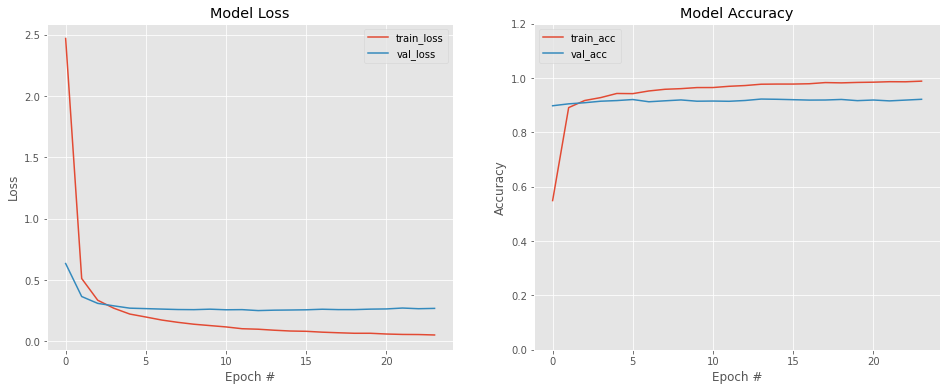


Starting fold 2

Training...
Evaluating model ...
213/213 [==============================] - 0s 1ms/step - loss: 0.0645 - accuracy: 0.9871


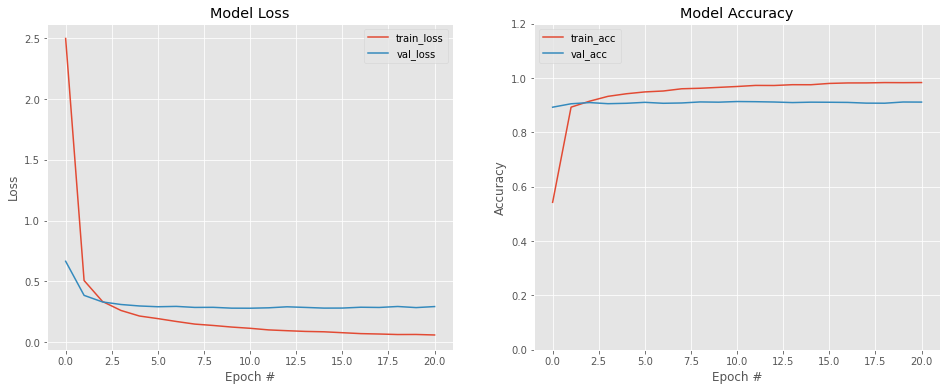


Starting fold 3

Training...
Evaluating model ...
213/213 [==============================] - 0s 1ms/step - loss: 0.1052 - accuracy: 0.9758


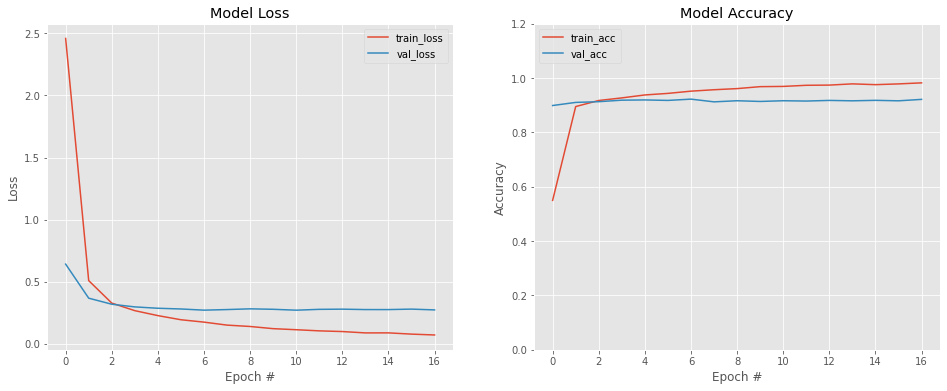


 CV Score -

TrainAccuracy - 0.984152098496755

TrainLoss - 0.07324001441399257

ValAccuracy - 0.9193892677625021

ValLoss - 0.26759318510691327


In [16]:
from sklearn.model_selection import StratifiedKFold

splits = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=10).split(final_train_features, Y))

trained_models = []
val_accuracy = []
val_losses = []
train_accuracy = []
train_losses = []

#Prepare And Train DNN model
for i, (train_idx, valid_idx) in enumerate(splits): 

    print(f"\nStarting fold {i+1}\n")
    x_train_fold = final_train_features[train_idx, :]
    y_train_fold = Yarr_hot[train_idx, :]
    x_val_fold = final_train_features[valid_idx]
    y_val_fold = Yarr_hot[valid_idx, :]

    dnn = keras.models.Sequential([
        InputLayer(final_train_features.shape[1:]),
        Dropout(0.7),
        Dense(120, activation='softmax')
    ])

    dnn.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    print("Training...")
    #Train simple DNN on extracted features.
    h = dnn.fit(x_train_fold, y_train_fold,
                batch_size=128,
                epochs=80,
                verbose=0,
                validation_data = (x_val_fold, y_val_fold),
                callbacks=my_callback)  # max 95.07
    print("Evaluating model ...")
    model_res_val = dnn.evaluate(x_val_fold, y_val_fold)
    model_res_train = dnn.evaluate(x_train_fold, y_train_fold)
    train_accuracy.append(model_res_train[1])
    train_losses.append(model_res_train[0])
    val_accuracy.append(model_res_val[1])
    val_losses.append(model_res_val[0])
    trained_models.append(dnn)
    plot_model_history(h, saving_name=f"fold_{i+1}_LA")
    

print('\n CV Score -')
print(f"\nTrainAccuracy - {sum(train_accuracy)/len(train_accuracy)}")
print(f"\nTrainLoss - {sum(train_losses)/len(train_losses)}")
print(f"\nValAccuracy - {sum(val_accuracy)/len(val_accuracy)}")
print(f"\nValLoss - {sum(val_losses)/len(val_losses)}")


In [17]:
# TEST IMAGES
test_images_list = sorted(os.listdir(os.path.join(data_dir, 'test')))
X = []
i = 0
for image in tqdm.tqdm(test_images_list):

    image_path = os.path.join(data_dir, 'test',image)
    orig_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    res_image = cv2.resize(orig_image,(img_size, img_size))
    X.append(res_image)
    i+=1

Xtesarr = np.array(X)

del(X)
gc.collect()

Xtesarr.shape

100%|███████████████████████████████████████████████████████████████████████████| 10357/10357 [00:22<00:00, 465.26it/s]


(10357, 363, 363, 3)

In [18]:
# FEATURE EXTRACTION OF TEST IMAGES
test_features = get_concat_features(get_valfeatures, models, preprocs, Xtesarr)

del(Xtesarr)
gc.collect()
print('Final feature maps shape', test_features.shape)

Beggining extraction with get_valfeatures


Starting feature extraction with DenseNet169 using preprocess_input

162/162 [==============================] - 48s 277ms/step
Feature maps
-  shape	 (10357, 1664)
-  dtype	 float32
- nbytes	 68936192 (65.74 MB)

Starting feature extraction with Xception using preprocess_input

162/162 [==============================] - 46s 273ms/step
Feature maps
-  shape	 (10357, 2048)
-  dtype	 float32
- nbytes	 84844544 (80.91 MB)

Starting feature extraction with InceptionResNetV2 using preprocess_input

162/162 [==============================] - 73s 430ms/step
Feature maps
-  shape	 (10357, 1536)
-  dtype	 float32
- nbytes	 63633408 (60.69 MB)
Final feature maps shape (10357, 5248)


In [19]:
y_pred_norm = trained_models[0].predict(test_features, batch_size=128)/3
for dnn in trained_models[1:]:
    y_pred_norm += dnn.predict(test_features, batch_size=128)/3

y_pred_norm.shape

df.iloc[:, 1:] = y_pred_norm
df.to_csv('submission.csv')


NameError: name 'df' is not defined